# Traveling Salesman problem

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
import random
from icecream import ic
import functools

## Download datasets

In [2]:
china=pd.read_csv('china.csv', names=['city','lat','lon'])
italy=pd.read_csv('italy.csv', names=['city','lat','lon'])
russia=pd.read_csv('russia.csv', names=['city','lat','lon'])
us=pd.read_csv('us.csv', names=['city','lat','lon'])
vanuatu=pd.read_csv('vanuatu.csv', names=['city','lat','lon'])

In [3]:
def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

## Problem creation

In [4]:
locations=russia.set_index('city').T.apply(tuple).to_dict()

In [5]:
def calculate_distance(loc1, loc2):
    R = 6371.0
    lat1 = math.radians(loc1['lat'])
    lon1 = math.radians(loc1['lon'])
    lat2 = math.radians(loc2['lat'])
    lon2 = math.radians(loc2['lon'])
    dlat = lat2-lat1
    dlon = lon2-lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [6]:
G=nx.Graph()
distances = {}
all_cities = []

for city in locations.keys():
    distances[city] = {}
    all_cities.append(city)

all_cities.sort()

# List of cities
cities = list(locations.keys())
num_cities = len(cities)

for city1 in all_cities:
    for city2 in all_cities:
        if city1!=city2:
            distance=calculate_distance(locations[city1],locations[city2])
            distances[city1][city2]=distance #We calculate every distances in between cities and put them indide a dictionnary
            G.add_edge(city1, city2, weight=distance)

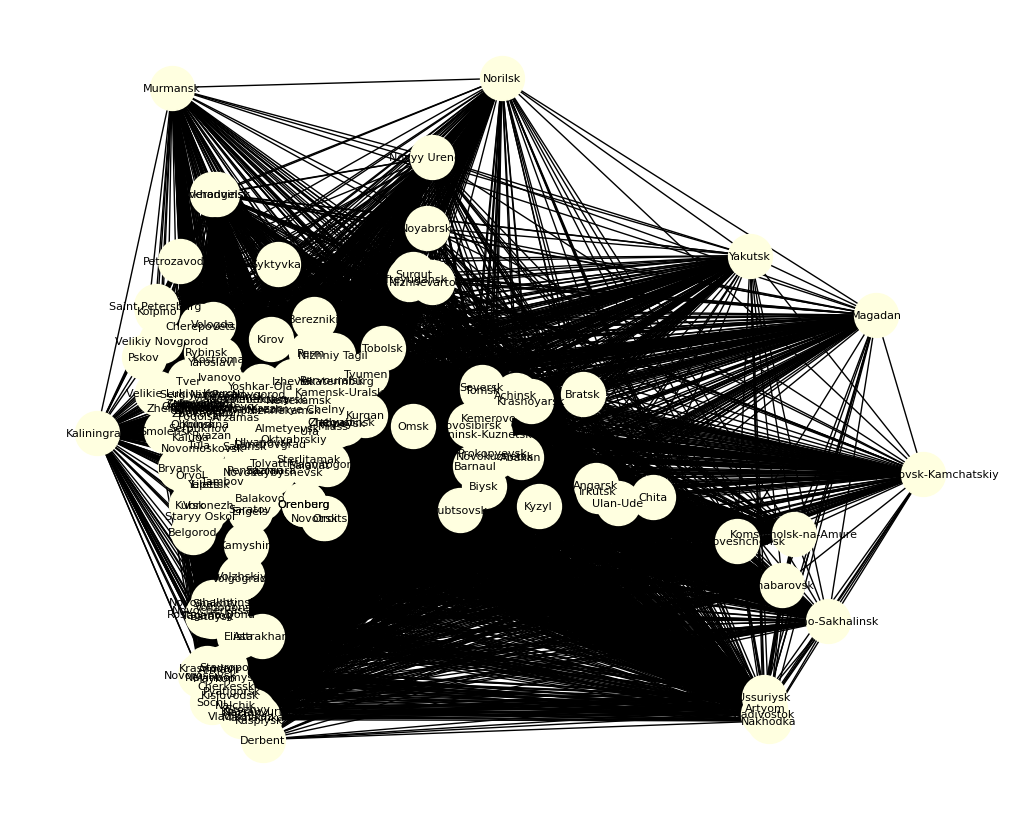

In [7]:
pos={city:(locations[city]['lon'],locations[city]['lat']) for city in locations}
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='lightyellow', node_size=1000, font_size=8)
plt.show()

In [8]:
def print_path(chemin,problem, title):
    G = nx.Graph()
    for i in range(len(chemin) - 1):
        city1 = chemin[i]
        city2 = chemin[i + 1]
        distance = calculate_distance(problem.locations[city1],problem.locations[city2])
        G.add_edge(city1, city2, weight=distance)
    G.add_edge(chemin[-1], chemin[0], weight=calculate_distance(problem.locations[ chemin[-1]],problem.locations[chemin[0]]))
    pos = {city: (locations[city]['lon'], locations[city]['lat']) for city in chemin}
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightpink', node_size=500, font_size=7)
    plt.title(title)
    plt.show()

In [9]:
class TSP_problem:
    def __init__(self, locations):
        self.locations = locations
        self.cities=list(locations.keys())
        self.number_cities=len(self.cities)
        self.initial = self.random_solution()
        
    def random_solution(self):
        return random.sample(self.cities[:],self.number_cities)
    
    @counter
    def value(self,state):
        cost = 0
        for i in range(len(state)-1):
            cost+=calculate_distance(self.locations[state[i]],self.locations[state[i+1]])
        cost += calculate_distance(self.locations[state[0]],self.locations[state[-1]])
        return cost
    
    def neighbour(self, state):#two_opt
        """ Neighbour generating function for Traveling Salesman Problem
        This function generates a neighbour state by reversing part of the path
        """
        neighbour_state = state[:]
        left = random.randint(0, len(neighbour_state) - 1)
        right = random.randint(0, len(neighbour_state) - 1)
        if left > right:
            left, right = right, left
        neighbour_state[left: right + 1] = reversed(neighbour_state[left: right + 1])
        return neighbour_state

## Fast solution: Greedy Algorithm with look ahead

In [10]:
def greedy(distances):
    start_city = random.choice(list(distances.keys()))

    tour = [start_city] #list of the city in the tour in the right order. At this point only contain the first city.
    visited = set(tour) #list of city already visited (we can not visit again)
    total_cost=0
    
    current_city = start_city
    while len(visited) < len(distances): 
        next_city = min((city for city in distances[current_city] if city not in visited),
            key=lambda city: distances[current_city][city])  #The next city is the closest one.
        tour.append(next_city) 
        visited.add(next_city)
        total_cost += distances[current_city][next_city] # We add the city to the tour,list of city visited and additionate the distance made.
        current_city = next_city
    
    tour.append(start_city)
    total_cost += distances[current_city][start_city]
    
    return tour, total_cost

In [11]:
problem = TSP_problem(locations)
best_solution, best_value = greedy(distances)  
print(f"Best solution found has cost: {best_value}")

Best solution found has cost: 43649.40639778614


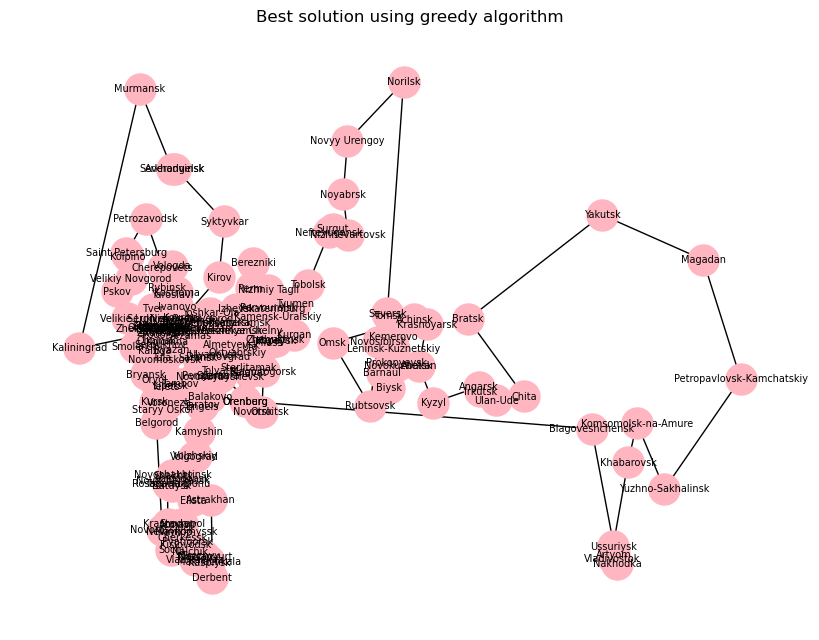

In [12]:
print_path(best_solution, problem, title="Best solution using greedy algorithm")

In [13]:
import random

def greedy_lookahead(distances):
    start_city=random.choice(list(distances.keys()))
    tour = [start_city] #list of the city in the tour in the right order. At this point only contain the first city.
    visited = set(tour) #list of city already visited (we can not visit again)
    total_cost = 0
    
    current_city = start_city
    while len(visited)<len(distances):
        next_city = min(
            (city for city in distances[current_city] if city not in visited),
            key=lambda city: min(
                (distances[current_city][city]+distances[city][next_city] 
                 for next_city in distances[city] if next_city not in visited and next_city != city),
                default=distances[current_city][city] #We do the same thing as for greedy algorithm but looking two cities ahead (shortest path going through two new cities)
            )
        )
        
        tour.append(next_city)
        visited.add(next_city)
        total_cost += distances[current_city][next_city] # We add the city to the tour,list of city visited and additionate the distance made.
        current_city = next_city
    
    tour.append(start_city)
    total_cost += distances[current_city][start_city]
    
    return tour, total_cost


In [14]:
problem = TSP_problem(locations)
best_solution, best_value = greedy_lookahead(distances) 
print(f"Best solution found has cost: {best_value}")

Best solution found has cost: 49175.65431251063


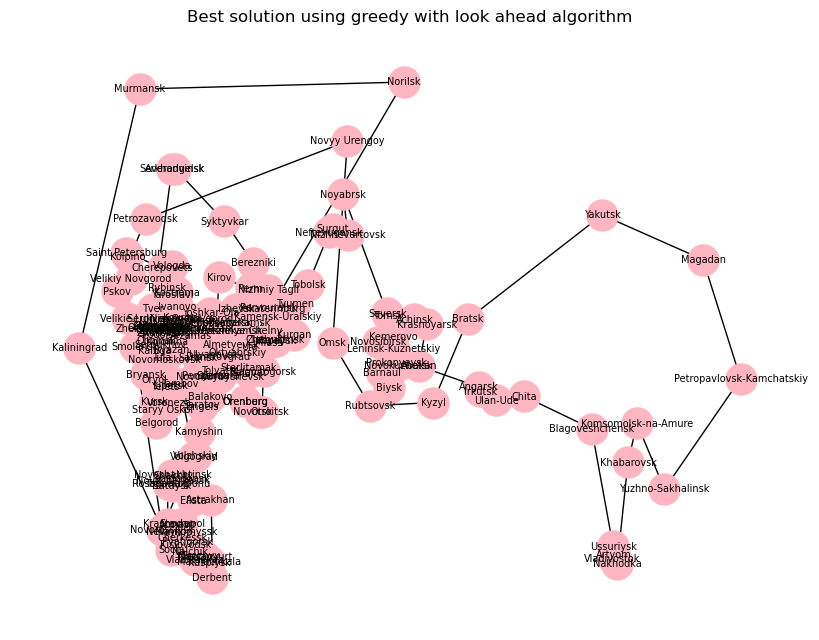

In [15]:
print_path(best_solution, problem, title="Best solution using greedy with look ahead algorithm")

# Precise solution: simulated annealing

In [16]:
def exponential_schedule(temperature=1000, alpha=0.999, limit=100):#This function describe the evolution of the temperature
    return lambda t: (temperature * np.exp(-alpha * t) if t < limit else 1e-3)

def simulated_annealing(problem, max_iterations=50,schedule=exponential_schedule(), max_evaluations=1000):
    # Initialisation de la solution
    current_solution = problem.random_solution()
    current_value = problem.value(current_solution)
    best_solution = current_solution
    best_value = current_value
    num_evaluations = 1
    costs = [current_value]
    temperature =schedule(0) #Initial temperature
    t=1

    while num_evaluations < max_evaluations and temperature >0:
        #Generate a Neighbour
        neighbour_solution=problem.neighbour(current_solution)
        neighbour_value=problem.value(neighbour_solution)
        num_evaluations+=1
        costs.append(neighbour_value)

        #If the neighbour is better we keep him
        if neighbour_value<current_value:
            current_solution=neighbour_solution
            current_value=neighbour_value
            if current_value<best_value:
                best_solution = current_solution
                best_value = current_value
                
                #print(best_value)
        else:
            #If the neighbour is not better we calculate the probability to keep it using the temperature
            probability = math.exp((current_value-neighbour_value)/temperature)
            if random.random()<probability:
                current_solution=neighbour_solution
                current_value=neighbour_value

        #We calculate the temperature (cooling it down)
        temperature=schedule(t)
        t+=1# Increment time step

    return best_solution, best_value, num_evaluations, costs


In [17]:
problem = TSP_problem(locations)
best_solution, best_value,evaluations, fit_list,  = simulated_annealing(problem=problem, max_iterations=100,  schedule=exponential_schedule(temperature=10_000, alpha=0.90, limit=200),max_evaluations=problem.number_cities*400)
print(f"Best solution found has cost: {best_value}")
print(f"Number of evaluations: {evaluations}")

Best solution found has cost: 35089.91227921185
Number of evaluations: 66800


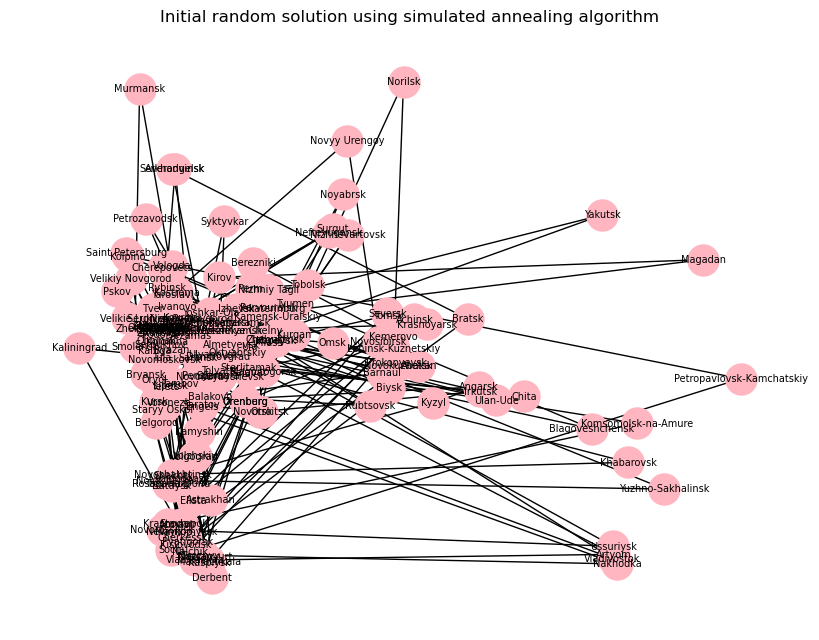

In [18]:
print_path(problem.initial, problem, title="Initial random solution using simulated annealing algorithm")

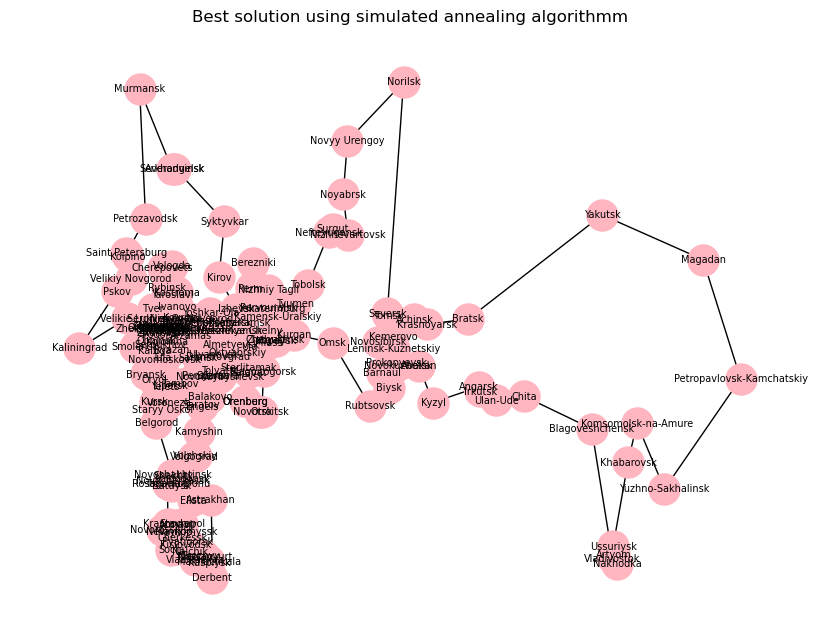

In [19]:
print_path(best_solution, problem, title="Best solution using simulated annealing algorithmm")

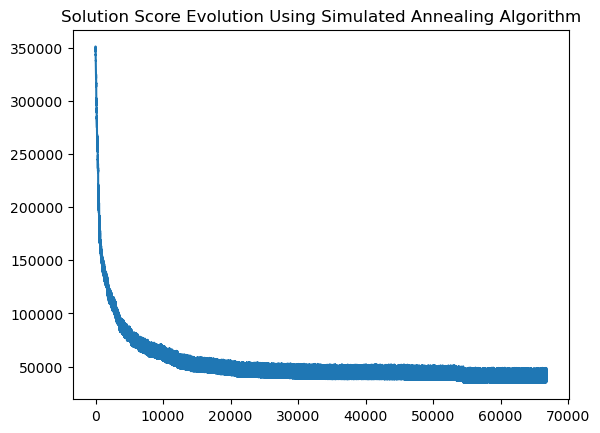

In [21]:
plt.plot(fit_list)
plt.title("Solution Score Evolution Using Simulated Annealing Algorithm")
plt.show()
